In [3]:
import sys
sys.path.append('./support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from sampler import fitters
from astropy.coordinates import SkyCoord
from astropy.table import Table
import GCRCatalogs

In [4]:
import clmm.polaraveraging as pa

### Read in the extragalactic catalog
- identify the most massive haloes in the catalog

In [5]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [6]:
stacked_gt = []
stacked_gterr = []
cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)

In [7]:
# get list of massive halos in a given redshift and mass range
mmin = 1.e14
mmax = 1.5e14
zmin = 0.3
zmax = 0.35

massive_halos = extragalactic_cat.get_quantities(['halo_mass', 'redshift','ra', 'dec'],\
                                                 filters=[f'halo_mass > {mmin}',f'halo_mass < {mmax}','is_central==True',
                                                          f'redshift>{zmin}', f'redshift<{zmax}'])

mass_list = massive_halos['halo_mass']
select = (mass_list == mass_list)

In [8]:
print(f"Stacking {len(mass_list)} clusters between in z = [{zmin}, {zmax}] and M = [{mmin:.1e},{mmax:.1e}]")

Stacking 19 clusters between in z = [0.3, 0.35] and M = [1.0e+14,1.5e+14]


- Loop over the cluster list and make binned profiles of each - these are saved in a single array

In [14]:
bin_edges = pa.make_bins(0.1, 4, 15, method='evenlog10width')

for i in range(len(select)):
    ra_cl = massive_halos['ra'][select][i]
    dec_cl = massive_halos['dec'][select][i]
    z_cl = massive_halos['redshift'][select][i]
    mass_cl = mass_list[select][i]
    
    # get galaxies around it
    ra_min, ra_max = ra_cl-0.3, ra_cl+0.3
    dec_min, dec_max = dec_cl-0.3, dec_cl+0.3
    z_min = z_cl + 0.3
    z_max = 1.5

    coord_filters = ['ra >= {}'.format(ra_min),'ra < {}'.format(ra_max),'dec >= {}'.format(dec_min),'dec < {}'.format(dec_max)]
    z_filters = ['redshift >= {}'.format(z_min),'redshift < {}'.format(z_max)]

    gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 'ra', 'dec', 'shear_1', 'shear_2', 'shear_2_phosim', 'shear_2_treecorr',\
                                            'redshift', 'convergence'], filters=(coord_filters + z_filters))

    # store the results into an astropy table
    dat = Table([gal_cat['ra'],gal_cat['dec'],gal_cat['shear_1'],\
          gal_cat['shear_2'],gal_cat['redshift'],gal_cat['galaxy_id']], \
          names=('ra','dec', 'e1', 'e2', 'z','id'))

    print(f"{i}, mass = {mass_cl:.2e}, ra = {ra_cl:.2f}, dec = {dec_cl:.2f}, z = {z_cl:.2f}, ngals = {len(dat)}")
    
    cl = clmm.GalaxyCluster('CL', ra_cl, dec_cl,
                               z_cl, dat)   
    
    cl.compute_shear(geometry="flat")
    profile = cl.make_shear_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)
    
    
    stacked_gt.append(profile['gt'])
    stacked_gterr.append(profile['gt_err'])

0, mass = 1.07e+14, ra = 64.19, dec = -39.69, z = 0.34, ngals = 398613
1, mass = 1.06e+14, ra = 63.92, dec = -41.70, z = 0.34, ngals = 375770
2, mass = 1.06e+14, ra = 69.70, dec = -42.95, z = 0.31, ngals = 291767
3, mass = 1.09e+14, ra = 68.37, dec = -44.46, z = 0.31, ngals = 370060
4, mass = 1.14e+14, ra = 68.55, dec = -44.35, z = 0.31, ngals = 368921
5, mass = 1.31e+14, ra = 69.05, dec = -43.44, z = 0.32, ngals = 364919
6, mass = 1.16e+14, ra = 66.90, dec = -45.28, z = 0.33, ngals = 340693
7, mass = 1.06e+14, ra = 64.90, dec = -33.20, z = 0.33, ngals = 315554
8, mass = 1.43e+14, ra = 65.47, dec = -34.42, z = 0.35, ngals = 419506
9, mass = 1.07e+14, ra = 65.58, dec = -35.92, z = 0.32, ngals = 401686
10, mass = 1.32e+14, ra = 65.66, dec = -36.43, z = 0.33, ngals = 404562
11, mass = 1.46e+14, ra = 66.19, dec = -36.84, z = 0.33, ngals = 412039
12, mass = 1.07e+14, ra = 62.46, dec = -37.00, z = 0.31, ngals = 417048
13, mass = 1.11e+14, ra = 61.74, dec = -37.77, z = 0.32, ngals = 411713
14

### Build the corresponding theoretical prediction from the average cluster mass.
Here we're using the source redshifts of the last cluster `dat['z']` as reference to average over the source redshift distribution.

In [23]:
m = np.mean(mass_list)
gt_red_model = np.zeros(len(profile))
gt_model = np.zeros(len(profile))
for i,r in enumerate(profile['radius']): 
    # Remember that CLMM modeling module works in units of Mpc/h, so need to account for it below
    gt_mod = clmm.predict_tangential_shear(r*cosmo.h,m, 4.,z_cl, dat['z'], cosmo,
                                                        delta_mdef=200,halo_profile_model='nfw')  
    gt_red_mod = clmm.predict_reduced_tangential_shear(r*cosmo.h,m, 4.,z_cl, dat['z'], cosmo,
                                                        delta_mdef=200,halo_profile_model='nfw')  
    gt_model[i] = np.mean(gt_mod)
    gt_red_model[i] = np.mean(gt_red_mod)

### Let's stack

For each bin, average the tangential shear values obtained for each clusters. For a detailed study on how to stack profiles, see https://arxiv.org/pdf/1802.09696.pdf (Eq.(34), $w(z_l,z_s) \gamma_T(\theta,z_s)$). At the moment, it's not clear whether the tangential shear computed from the cosmoDC2 `shear1` and `shear2` fields should be compared to the reduced or not tangential shear. Both options are plotted below. In the regime before the drop out at low radii (due to DC2 resolution?) the difference between shear and reduced shear is negligible.

Final warning, the CLMM modeling default is not use M200 while the masses reported in the cosmoDC2 catalog are FOF masses. One would need M200 for the DC2 catalog to make a more meaningful comparison.

Text(0, 0.5, '<shear>')

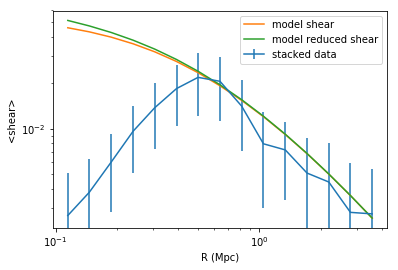

In [33]:
plt.errorbar(profile['radius'],np.nanmean(stacked_gt,axis=0),yerr=np.nanstd(stacked_gt,axis=0), label='stacked data')
plt.plot(profile['radius'],gt_model, label='model shear')
plt.plot(profile['radius'],gt_red_model, label='model reduced shear')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (Mpc)')
plt.ylabel('<shear>')